# OnOff

+ nameGenerator -> lista -> nombre
+ nameObtainer -> nombre -> lista
+ Save Rasters -> nombre,listado N
+ GenerateSets -> nombre:listadoN (ex cargaDataset)
+ modelsMatlablines -> eliminado
+ Run malab directo con los nombres de archivo
+ Predecir directo con el nombre de archivo -> save file with individual predictions
+ Metricas idem: nombre->plot?


Selección de umbral

Cuántas neuronas se requieren para alcanzar el umbral
+ determinar esta metrica y el umbral
+ comparar con grupos de neuronas fuera del ensemble cuando se pueda tamaño medio
+ elección de ensemble según participación del raster y según tamaño
+ on cuando selecciones tipo on y con tipo off
+ off prediciendo con tipo on y tipo off

Realizar el promedio de cuántas neuronas se requieren para alcanzar tal umbral dentro de cada ensemble


JVM Started
Returning PreComputed MIMatrix on_off_verde_raster_core_cells


/opt/miniconda/envs/jupyterhub/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/miniconda/envs/jupyterhub/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


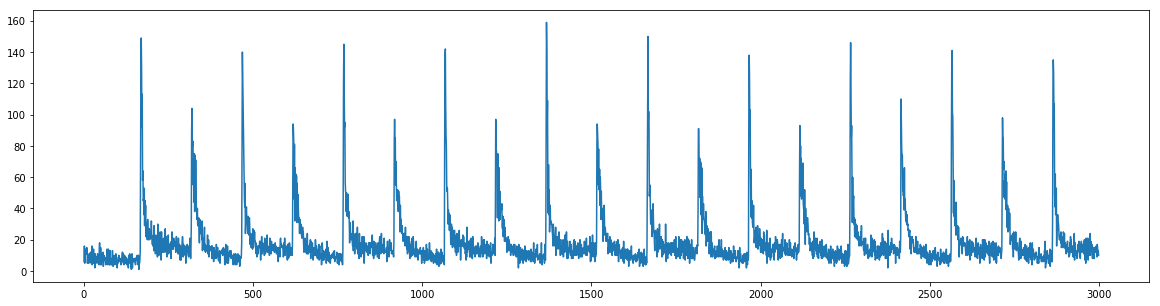

(319, 12998)


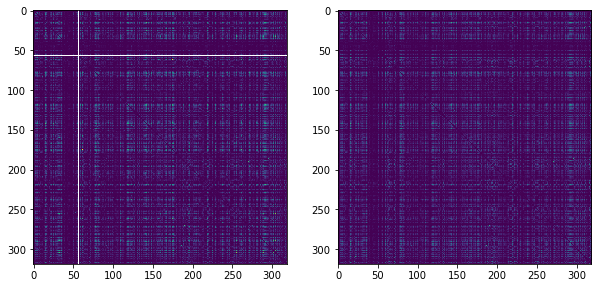

In [1]:
### 1 - Preliminares

#### Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import os
import pickle
from matplotlib.ticker import ScalarFormatter
from ipywidgets import interact,IntSlider
from scipy.io import loadmat,savemat
from scipy.ndimage.filters import gaussian_filter1d
from scipy import sparse
from json import loads,dumps
from jpype import *
from JITDWrapper import *
from sklearn.manifold import MDS
from scipy.spatial import ConvexHull

%matplotlib inline


import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict


def dataLoader(file):
    rasterfile = "../Data/OnOff/"+file
    if os.path.isfile(rasterfile+".npz"):
        print("Returning saved sparse matrix",rasterfile.split("/")[-1])
        raster = sparse.load_npz(rasterfile+".npz")
        raster = raster.toarray()
        return raster,raster.shape[0]
    data = loadmat("../Data/OnOff/"+file+".mat")["on_off_data"]["raster"]
    return data,data.shape[0]


def MutualInformation(file):
    mifile="../Data/OnOff/"+file
    if os.path.isfile(mifile+".npy"):
        print ("Returning PreComputed MIMatrix "+mifile.split("/")[-1])
        return np.load(mifile+".npy")
    raster,Ncount = dataLoader(file)
    calcClass = JPackage("infodynamics.measures.discrete").MutualInformationCalculatorDiscrete
    calc = calcClass(2, 2, 0)
    MI = np.zeros((Ncount,Ncount))
    for S in range(Ncount):
        source = JArray(JInt, 1)(raster[S].tolist())
        for D in range(S,Ncount):
            if S==D: continue;
            destination = JArray(JInt, 1)(raster[D].tolist())
            calc.initialise()
            calc.addObservations(source, destination)
            MI[S][D]=calc.computeAverageLocalOfObservations()
        print(S," ",end="")
    np.save(mifile,MI)
    return MI


def loadEnsembles():
    data = loadmat("../Data/OnOff/on_off_verde_raster_core_cells.mat")["on_off_data"]["core_cells"]
    return dict([(e,np.where(data[:,e]==1)[0]) for e in range(10)])


def loadOnOff():
    #0=Null, 1=ON, 2=OFF, 3=On-Off
    onoff = loadmat("../Data/OnOff/on_off_list.mat")["on_off_clases"]
    return dict([(c,np.where(onoff==c)[0]) for c in range(4)])


typedict = loadOnOff()
TBASE = 0.02 #0.001 = 1ms
RASTER = dataLoader("on_off_verde_raster_core_cells")[0]
E = loadEnsembles()
INTERVAL = 50 # para SpRate
N,T = RASTER.shape
ctype = loadOnOff()
RASTER = np.hstack([RASTER]*2)

o=165
p=150
ontimes = np.hstack([list(range(o+p*n,o+p*(n+1))) for n in range(0,100,2) if (o+p*n+1<T)])
offtimes = np.hstack([list(range(o+p*n,o+p*(n+1))) for n in range(1,100,2) if (o+p*n+1<T)])
onRaster = RASTER[:,ontimes]
offRaster = RASTER[:,offtimes]

MI = MutualInformation("on_off_verde_raster_core_cells")
MI = MI+MI.T
CC = np.corrcoef(RASTER[:50],RASTER[50:])**2-np.diag(np.ones(N))
#RASTER = np.hstack([RASTER]*5)
onRaster = np.hstack([onRaster]*5)
offRaster = np.hstack([offRaster]*5)

#Miniplot
plt.figure(figsize=(20,5))
plt.plot(np.sum(RASTER,axis=0)[:3000])
plt.show()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(CC)
plt.subplot(1,2,2)
plt.imshow(MI)
print(RASTER.shape)

In [2]:
print(len(set(E[0])&set(ctype[2])),len(set(E[5])&set(ctype[1])))
print(len(E[0]),len(ctype[2]))
print(len(E[5]),len(ctype[1]))
E[10] = np.array(list(set(E[0])&set(ctype[2]))) # Ensemble 0 intersec OFF
E[11] = np.array(list(set(E[5])&set(ctype[1])))# Ensemble 5 intersec ON

21 43
66 25
73 57


In [3]:
for e in E:
    print(e,len(E[e]),np.round(np.mean(np.mean(RASTER[E[e]],axis=1)),3))
print(len(np.unique(np.hstack([E[i] for i in range(5,10)]))))
print(len(np.unique(np.hstack([E[i] for i in range(5)]))))

0 66 0.099
1 257 0.049
2 222 0.058
3 26 0.155
4 31 0.138
5 73 0.087
6 33 0.125
7 49 0.109
8 38 0.126
9 62 0.098
10 21 0.117
11 43 0.081
142
315


In [41]:
def generateSets(setsname):
    #Ensemble 0, N nro.neurona, S set elegido (1 dentro 0 fuera) fijasD nro de sample
    #E_N_S_F_D.mat
    if setsname+".json" in os.listdir("../Data/OnOff/"):
        print("Loaded")
        with open("../Data/OnOff/{}.json".format(setsname)) as O:
            return loads(O.readline())
    sets=[]
    for e in [11]:
        for n in E[e][:2]:
            for s in [1]:
                for f in range(5,len(E[e]),5):
                    for d in range(2):
                        if s==0:
                            sample = np.random.choice(np.where(~np.in1d(np.arange(N),E[e]))[0],f)
                        else:
                            sample = np.random.choice(E[e][~np.in1d(E[e],[n])],f)
                        sets.append(("{}_{}_{}_{}_{}.mat".format(e,n,s,f,d),[e,int(n),s,f,d],list(map(int,[n]+list(sample)))))
    with open("../Data/OnOff/{}.json".format(setsname),"w") as O:
        O.write(dumps(sets))
    return sets

Sets = generateSets("E0interoff")
nSets = [["off"+a,b,c] for a,b,c in Sets]
print(len(Sets))

Loaded
16


In [161]:
#print(np.random.choice(np.where(~np.in1d(E[0],[0]))[0],10))
print(np.random.choice(E[0][~np.in1d(E[0],[0])],4))
print(E[0],E[0][:2])

[108 178 108 133]
[  0   1   6   9  10  12  19  21  24  25  27  31  40  44  46  47  48  49
  50  52  59  60  61  64  65  67  79  80  86  87  88 100 108 111 117 120
 132 133 135 137 142 143 147 148 154 159 162 177 178 192 198 201 215 216
 217 227 231 232 248 263 283 293 294 300 305 318] [0 1]


In [27]:
names= [ a for a,b,c in nSets]
print(names)

['on11_2_1_5_0.mat', 'on11_2_1_5_1.mat', 'on11_2_1_10_0.mat', 'on11_2_1_10_1.mat', 'on11_2_1_15_0.mat', 'on11_2_1_15_1.mat', 'on11_2_1_20_0.mat', 'on11_2_1_20_1.mat', 'on11_2_1_25_0.mat', 'on11_2_1_25_1.mat', 'on11_2_1_30_0.mat', 'on11_2_1_30_1.mat', 'on11_2_1_35_0.mat', 'on11_2_1_35_1.mat', 'on11_2_1_40_0.mat', 'on11_2_1_40_1.mat', 'on11_258_1_5_0.mat', 'on11_258_1_5_1.mat', 'on11_258_1_10_0.mat', 'on11_258_1_10_1.mat', 'on11_258_1_15_0.mat', 'on11_258_1_15_1.mat', 'on11_258_1_20_0.mat', 'on11_258_1_20_1.mat', 'on11_258_1_25_0.mat', 'on11_258_1_25_1.mat', 'on11_258_1_30_0.mat', 'on11_258_1_30_1.mat', 'on11_258_1_35_0.mat', 'on11_258_1_35_1.mat', 'on11_258_1_40_0.mat', 'on11_258_1_40_1.mat']


In [28]:
### 3 - Creación de modelos
#### Código para exportar a archivos MATLAB
def saveRasters(filename,neuronlist):
    savemat("../Data/OnOff/Rasters/{0}".format(filename),
            {"binnedSpikes":RASTER[neuronlist]})

def run_matlab(filename,back=0):
    print("""matlab -nodisplay -nosplash -nodesktop -r "cd('MatlabIsing');Ajustar('../../Data/OnOff/Rasters','../../Data/OnOff/Models','{}');exit()" """.format(filename)+["","&"][back])
    os.system("""matlab -nodisplay -nosplash -nodesktop -r "cd('MatlabIsing');Ajustar('../../Data/OnOff/Rasters','../../Data/OnOff/Models','{}');exit()" """.format(filename)+["","&"][back])


In [29]:
RASTER=onRaster
for fn,_,nlist in nSets:
    saveRasters(fn,nlist)
    print(fn,end="\t")

on11_2_1_5_0.mat	on11_2_1_5_1.mat	on11_2_1_10_0.mat	on11_2_1_10_1.mat	on11_2_1_15_0.mat	on11_2_1_15_1.mat	on11_2_1_20_0.mat	on11_2_1_20_1.mat	on11_2_1_25_0.mat	on11_2_1_25_1.mat	on11_2_1_30_0.mat	on11_2_1_30_1.mat	on11_2_1_35_0.mat	on11_2_1_35_1.mat	on11_2_1_40_0.mat	on11_2_1_40_1.mat	on11_258_1_5_0.mat	on11_258_1_5_1.mat	on11_258_1_10_0.mat	on11_258_1_10_1.mat	on11_258_1_15_0.mat	on11_258_1_15_1.mat	on11_258_1_20_0.mat	on11_258_1_20_1.mat	on11_258_1_25_0.mat	on11_258_1_25_1.mat	on11_258_1_30_0.mat	on11_258_1_30_1.mat	on11_258_1_35_0.mat	on11_258_1_35_1.mat	on11_258_1_40_0.mat	on11_258_1_40_1.mat	

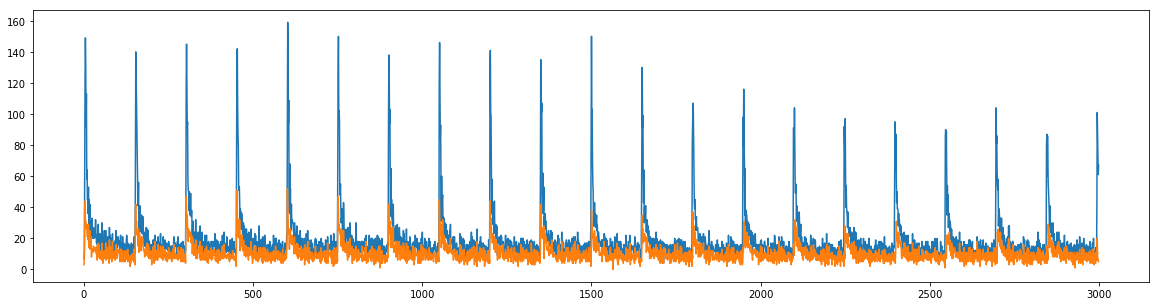

In [169]:
RASTER=onRaster
miniR = RASTER[np.unique(np.hstack([E[i] for i in [5]])),:]
plt.figure(figsize=(20,5))
plt.plot(np.sum(RASTER,axis=0)[:3000])
plt.plot(np.sum(miniR,axis=0)[:3000])
plt.show()

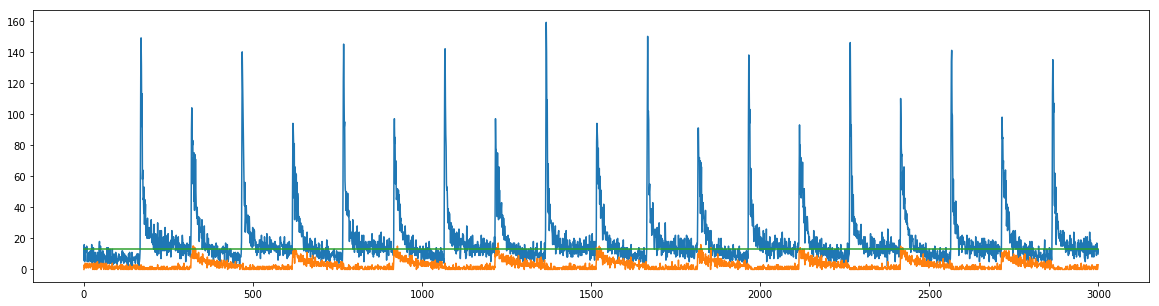

(319, 27300)


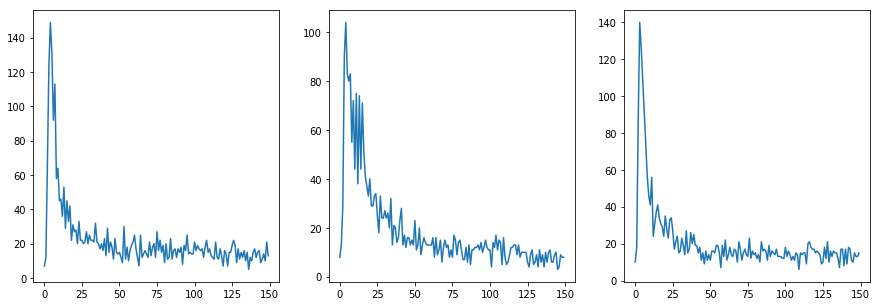

In [114]:
nopeak = RASTER[:,np.sum(RASTER,axis=0)<30]
nopeak = nopeak[:,np.sum(nopeak,axis=0)>5]
miniR = RASTER[np.unique(np.hstack([E[i] for i in [7]])),:]
plt.figure(figsize=(20,5))
#plt.plot(np.sum(nopeak,axis=0)[:3000])
plt.plot(np.sum(RASTER,axis=0)[:3000])
plt.plot(np.sum(RASTER[ctype[2],:],axis=0)[:3000])
av = np.mean(np.sum(nopeak,axis=0))

plt.plot([0,3000],[av,av])
plt.show()
print(nopeak.shape)
offset=165
period=150
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(np.sum(RASTER[:,offset:offset+period],axis=0))
plt.subplot(1,3,2)
plt.plot(np.sum(RASTER[:,offset+period:offset+2*period],axis=0))
plt.subplot(1,3,3)
plt.plot(np.sum(RASTER[:,offset+2*period:offset+3*period],axis=0))
plt.show()

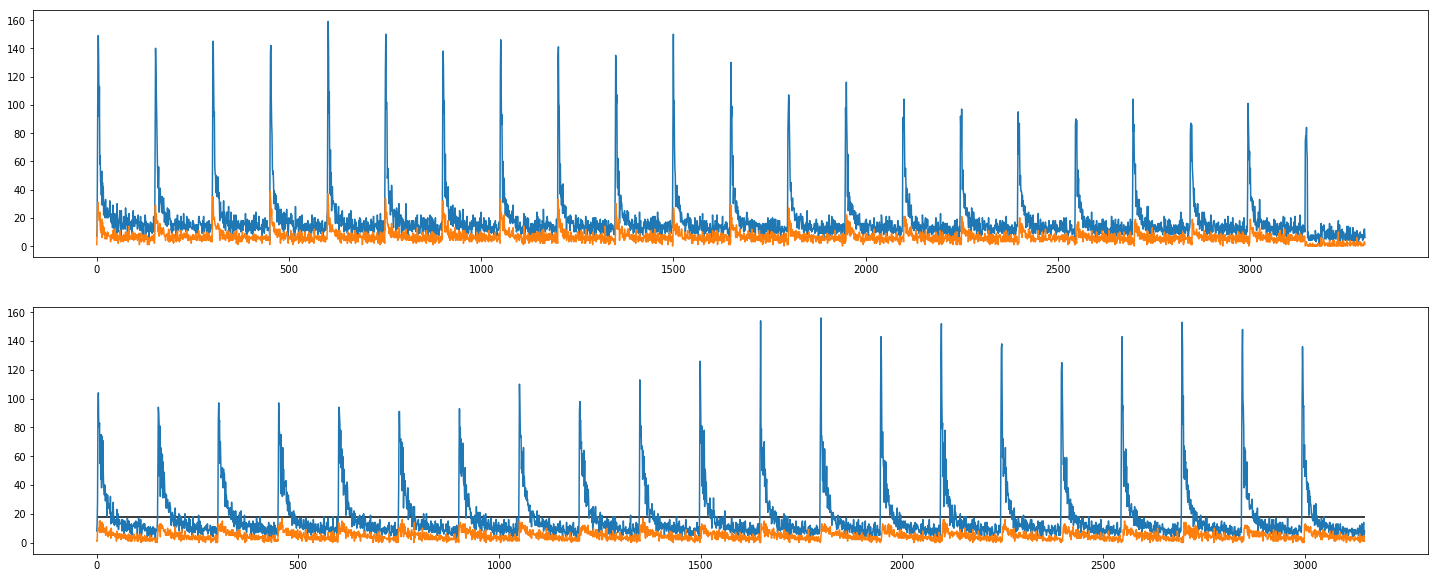

In [22]:
plt.figure(figsize=(25,10))
plt.subplot(2,1,1)
plt.plot(np.sum(onRaster,axis=0))
plt.plot(np.sum(onRaster[ctype[1],:],axis=0))
plt.subplot(2,1,2)
plt.plot(np.sum(offRaster,axis=0))
plt.hlines(np.mean(np.sum(offRaster,axis=0)),0,len(offtimes))
plt.plot(np.sum(offRaster[ctype[2],:],axis=0))
plt.show()

In [ ]:

def runMatlabx5(filenames):
    for subset in range(len(filenames))[::5]:
        sf = filenames[subset:subset+5]
        run_matlab(sf[0][0],1)
        run_matlab(sf[1][0],1)
        run_matlab(sf[2][0],1)
        run_matlab(sf[3][0],1)
        print(subset,end="|")
        run_matlab(sf[4][0],0)

runMatlabx5(nSets)

matlab -nodisplay -nosplash -nodesktop -r "cd('MatlabIsing');Ajustar('../../Data/OnOff/Rasters','../../Data/OnOff/Models','on11_2_1_5_0.mat');exit()" &
matlab -nodisplay -nosplash -nodesktop -r "cd('MatlabIsing');Ajustar('../../Data/OnOff/Rasters','../../Data/OnOff/Models','on11_2_1_5_1.mat');exit()" &
matlab -nodisplay -nosplash -nodesktop -r "cd('MatlabIsing');Ajustar('../../Data/OnOff/Rasters','../../Data/OnOff/Models','on11_2_1_10_0.mat');exit()" &
matlab -nodisplay -nosplash -nodesktop -r "cd('MatlabIsing');Ajustar('../../Data/OnOff/Rasters','../../Data/OnOff/Models','on11_2_1_10_1.mat');exit()" &
0|matlab -nodisplay -nosplash -nodesktop -r "cd('MatlabIsing');Ajustar('../../Data/OnOff/Rasters','../../Data/OnOff/Models','on11_2_1_15_0.mat');exit()" 
matlab -nodisplay -nosplash -nodesktop -r "cd('MatlabIsing');Ajustar('../../Data/OnOff/Rasters','../../Data/OnOff/Models','on11_2_1_15_1.mat');exit()" &
matlab -nodisplay -nosplash -nodesktop -r "cd('MatlabIsing');Ajustar('../../Data/On

In [31]:
# Del total de nuevos modelos cuantos faltan
def checkModelStatus():
    modelcont = os.listdir("../Data/OnOff/Models/")
    rastercont = os.listdir("../Data/OnOff/Rasters/")
    rematlines=[f for f in rastercont if f not in modelcont]
    print("Rasters:",len(rastercont),"Not Processed:",len(rematlines))
    print ("Remaining:",len(set(rastercont)-set(modelcont)),"Done:",len(modelcont))
    return modelcont,rematlines

def cleanRasters():
    for elem in modelcont:
        if elem in rastercont:
            os.system("rm ../Data/OnOff/Rasters/"+elem) #deleting raster with model ready
            print("|",end="")

done,remaining = checkModelStatus()
print(sum([f[0] in done for f in nSets]))


Rasters: 2944 Not Processed: 1866
Remaining: 1866 Done: 1079
15


In [35]:
### 4 - Cómputo de predicciones
#### Función de predicción de raster o spikerate en base al modelo

def PredecirSpRate(filename,params,nlist): #neurona,ranking,particion_entreno,fijas,set,particion_eval
    #Carga indices de neuronas y ajusta datos
    filename = filename[:-4]
    #if "{}.npy".format(filename) in os.listdir("../Data/OnOff/Predictions/"):
    #    return np.load("../Data/OnOff/Predictions/"+filename+".npy",allow_pickle=True)
    _,n,_,f,_ = params
    data = RASTER[nlist,:]
    N = f+1
    #print(filename) #DEBUG PRINT
    #Carga el modelo
    ising = loadmat("../Data/OnOff/Models/{}.mat".format(filename))
    params = ising["params"] # N , N*(N-1)/2
    #print(params.shape,N,params)
    P = np.zeros((N,N)) #FullMatrix for indexing
    P[np.triu_indices(N, 1)] = params[N:] #UpperTri Matrix
    P = P+np.diag(params[:N]) #<h,sigma>
    #Calcula la probabilidad
    obtRate = []
    for t in range(data.T.shape[0]):
        selected = np.array([[1.0]+data.T[t][1:N].tolist(), [0.0]+data.T[t][1:N].tolist()]) # 1/0 + data 1:N
        prob_denom = np.sum(np.exp(np.sum(np.matmul(selected,P)*selected,1))) #Prob P(given)
        selected = np.array([[1.0]+data.T[t][1:N].tolist()]) #1 + data 1:N
        prob_num = np.sum(np.exp(np.sum(np.matmul(selected,P)*selected,1))) #Prob P(target,given)
        obtRate.append(prob_num/prob_denom)
    
    #SpikeRate Forward Moving Window
    spRate = np.array([np.sum(data[0][i:i+50]) for i in range(0,data.T.shape[0]-50)])/(1/TBASE)
    spRatePred = np.array([np.sum(obtRate[i:i+50]) for i in range(0,data.T.shape[0]-50)])/(1/TBASE)
    np.save("../Data/OnOff/Predictions/"+filename,np.array([obtRate,spRatePred]))
    return obtRate,spRatePred


In [174]:
for fn,par,nlist in nSets:
    if fn in done:
        PredecirSpRate(fn,par,nlist)
    print(fn,end=" - ")

x5_2_1_5_0.mat - x5_2_1_5_1.mat - x5_2_1_10_0.mat - 

/opt/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


x5_2_1_10_1.mat - x5_2_1_15_0.mat - x5_2_1_15_1.mat - x5_2_1_20_0.mat - x5_2_1_20_1.mat - x5_2_1_25_0.mat - x5_2_1_25_1.mat - x5_2_1_30_0.mat - x5_2_1_30_1.mat - x5_2_1_35_0.mat - x5_2_1_35_1.mat - 

In [46]:
### 5 - Cálculo de métricas
#### Función para calcular las métricas en base a una predicción
def ObtenerMetricas(filename,params,nlist):
    #Original Data
    data = RASTER[nlist[0],:]
    spRate = np.array([np.sum(data[i:i+50]) for i in range(0,data.T.shape[0]-50)])/(1/TBASE)

    # Predicted Data
    preData,preSp = PredecirSpRate(filename,params,nlist)
    #print (len(data),len(spRate),len(preData),len(preSp))
    #Raw Distance|R and SpRate Distance|R
    dataDist = np.round(np.linalg.norm(data-preData),3)
    dataR = np.round(np.corrcoef(data,preData)[0,1],3)
    spDist = np.round(np.linalg.norm(spRate-preSp),3)
    spR = np.round(np.corrcoef(spRate,preSp)[0,1],3)
    return [(dataDist,dataR),(spDist,spR)]


results = {}
for fn,par,nlist in nSets:
    if fn in done:
        results[fn]=ObtenerMetricas(fn,par,nlist)
        print(fn,end=" - ")


/opt/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in matmul
/opt/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in matmul
/opt/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


n0_0_1_5_1.mat - n0_0_1_15_1.mat - n0_0_1_20_0.mat - n0_0_1_25_0.mat - n0_0_1_25_1.mat - n0_0_1_30_0.mat - n0_0_1_30_1.mat - 

In [42]:
RASTER = offRaster
SP = np.array([np.sum(RASTER[:,i:i+50],axis=1) for i in range(0,T-50)])/(1/TBASE)
donesets = [(a,b,c) for a,b,c in nSets if a in done]

In [43]:
@interact(n=(0,len(donesets)))
def showpred(n):
    plt.figure(figsize=(20,5))
    plt.plot(SP[:,0])
    #for n in range(39):
    rate,spr = PredecirSpRate(*donesets[n])
    print(spr[:10],rate[:10])
    plt.title(donesets[n][0])
    plt.plot(spr[:6000])
    plt.show()
#plt.plot(SP[:,1])
#plt.plot(SP[:,2])
#plt.plot(SP[:,3])
#plt.plot(SP[:,4])

interactive(children=(IntSlider(value=4, description='n', max=9), Output()), _dom_classes=('widget-interact',)…

In [ ]:
for e in [0]:
    for n in E[e][:2]:
        for s in [0,1]:
            for d in range(3):
                x,y = [],[]
                for f in range(5,len(E[e]),10):
                    fn="{}_{}_{}_{}_{}.mat".format(e,n,s,f,d)
                    if fn not in done:
                        continue
                    x.append(f)
                    y.append(results[fn][1][1]**2)
                plt.plot(x,y,label=str(n),color=["red","blue"][s],alpha=0.4)
                        
plt.show()

In [86]:
results["0_132_1_15_0.mat"]

KeyError: '0_132_1_15_0.mat'

# WorkFlow

In [ ]:
# TP = 147
#medidas = {(r,0,f,s,pp)
# (p,pp) -> (0,0), (1,1), (1,2)
def measurePlotter(TP,pconv,plotfile):
    #predicciones = cargarPredicciones(TP)
    #print(TP)
    medidas = cargarMedidas(TP)
    plt.figure(figsize=(15,5))
    p,pp = [(0,0),(1,1),(1,2)][pconv]
    med = ["Distance","$R^2$"]
    tip = ["Spikes","Spike Rates"]
    A = 6
    B = 15
    for t in [0]:
        for m in [0,1]:
            #plt.figure(figsize=(16,15))
            #plt.subplot(4,1,m*2+t+1)
            plt.subplot(1,2,m+1)
            plt.xlabel("N");plt.ylabel(med[m])
            rand = [np.array([medidas[(0,p,f,s,pp)][t][m] for f in NsR[:A]]) for s in range(5)]
            irand = [np.array([medidas[(1,p,f,s,pp)][t][m] for f in NsR[:A]]) for s in range(5)]
            stdrand = np.std(rand,axis=0)
            stdirand = np.std(irand,axis=0)
            plt.plot(NsR[:A],sum(rand)/5,"k-",alpha=0.3,label="AvgRandom")
            plt.fill_between(NsR[:A], sum(rand)/5 - stdrand, sum(rand)/5 + stdrand, alpha=0.05,color="k")
            plt.plot(NsR[:A],sum(irand)/5,"b-",alpha=0.3,label="AvgRandom I")
            plt.fill_between(NsR[:A], sum(irand)/5 - stdirand, sum(irand)/5 + stdirand, alpha=0.05,color="b")
            #for s in range(4):
            #    plt.plot(NsR[:A],[medidas[(0,p,f,s,pp)][t][m] for f in NsR[:A]],"k.")
            #    plt.plot(NsR[:A],[medidas[(1,p,f,s,pp)][t][m] for f in NsR[:A]],"b-",alpha=0.3)
            plt.plot(Ns[:B],[medidas[(2,p,f,0,pp)][t][m] for f in Ns[:B]],"r-",alpha=0.3,label="MI")
            plt.plot(Ns[:B],[medidas[(3,p,f,0,pp)][t][m] for f in Ns[:B]],"g-",alpha=0.3,label="RF")
            #plt.plot(Ns[:B],[medidas[(4,p,f,0,pp)][t][m] for f in Ns[:B]],"k-",alpha=0.3,label="Correl")
            plt.legend()
            plt.title("Neuron {0} - {2} {1}".format(TP,med[m],tip[t]))
    plt.savefig("plot{0}".format(dataset["fixed"])+plotfile+".svg")

for n in [51, 33, 64, 71, 19]:
    measurePlotter(n,0,"FF")

n0_0_0_15_0.mat


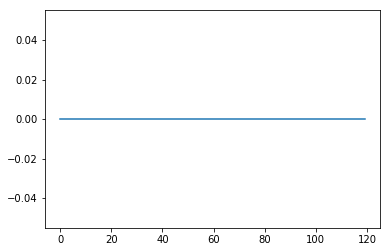

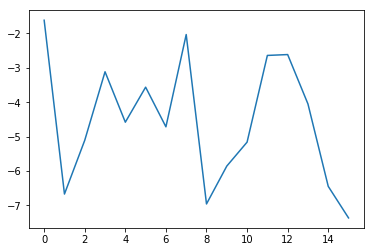

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [[-1.61631079  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]


In [71]:
def showModel(filename,N):
    print(filename)
    ising = loadmat("../Data/OnOff/Models/{}".format(filename))
    params = ising["params"] # N , N*(N-1)/2
    #print(params[:,0],len(params[:,0]),N)
    P = np.zeros((N,N)) #FullMatrix for indexing
    P[np.triu_indices(N, 1)] = params[N:] #UpperTri Matrix
    H = np.diag(params[:N]) #<h,sigma>
    #sns.distplot(params[N:])
    plt.plot(range(len(params[N:])),params[N:])
    plt.show()
    plt.plot(range(N),params[:N])
    plt.show()
    print(P,H)

showModel("n0_0_0_15_0.mat",16)

# No considerar de acá hacia abajo

In [ ]:
import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict
NEWFILES = loadmat("../Data/Fishmovie/IST-2017-61-v1+1_bint_fishmovie32_100.mat")

def dataLoader(file):
    rasterfile = "../Data/OnOff/"+file
    if os.path.isfile(rasterfile+".npz"):
        print("Returning saved sparse matrix",rasterfile.split("/")[-1])
        raster = sparse.load_npz(rasterfile+".npz")
        raster = raster.toarray()
        return raster,raster.shape[0]
    data = loadmat("../Data/OnOff/"+file+".mat")["on_off_data"]["raster"]
    return data,data.shape[0]


def MutualInformation(file):
    mifile="../Data/OnOff/"+file
    if os.path.isfile(mifile+".npy"):
        print ("Returning PreComputed MIMatrix "+mifile.split("/")[-1])
        return np.load(mifile+".npy")
    raster,Ncount = dataLoader(file)
    calcClass = JPackage("infodynamics.measures.discrete").MutualInformationCalculatorDiscrete
    calc = calcClass(2, 2, 0)
    MI = np.zeros((Ncount,Ncount))
    for S in range(Ncount):
        source = JArray(JInt, 1)(raster[S].tolist())
        for D in range(S,Ncount):
            if S==D: continue;
            destination = JArray(JInt, 1)(raster[D].tolist())
            calc.initialise()
            calc.addObservations(source, destination)
            MI[S][D]=calc.computeAverageLocalOfObservations()
        print(S," ",end="")
    np.save(mifile,MI)
    return MI

R,n = dataLoader("on_off_verde_raster_core_cells")
mi = MutualInformation("on_off_verde_raster_core_cells")

In [ ]:
[a for a,b in sorted(enumerate(np.sum(r,axis=1)/r.shape[1]),key=lambda x:x[-1],reverse=True)][:10]

In [ ]:
E[[52,24,185,315,168]]
E[:,-1]

In [ ]:
r,n = dataLoader("on_off_verde_raster_core_cells")
mi = MutualInformation("on_off_verde_raster_core_cells")
E = loadEnsembles()

In [ ]:

MIsum = []
for e in range(E.shape[1]):
    cMI=MI.copy()
    cMI[~E[:,e].astype(bool)] = 0
    cMI[:,~E[:,e].astype(bool)] = 0
    MIsum.append(np.sum(cMI,axis=0)/np.sum(E[:,e]))
MIsum = np.vstack(MIsum).T
MIsum.shape

In [ ]:
# Para cada neurona de cada ensemble se calcula el Avg MI de cada ensemble que pertenece
# Para cada neurona se generan selecciones aleatorias de neuronas del tamaño de cada ensemble al que pertenecen y se calcula lo mismo
# Esperado: avgMI de los ensembles suele ser mayor que el promedio de selecciones aleatorias
@interact(n=range(E.shape[0]))
def plotAvgMi(n):
    S = 50 #samples
    for e in range(E.shape[1]):
        eSize=np.sum(E[:,e])
        sel = np.array([1]*eSize+[0]*int(E.shape[0]-eSize))
        for s in range(S):
            np.random.shuffle(sel)
            #print(sel)
            plt.scatter([e],[np.sum(MI[n][sel.astype(bool)])/eSize],color="k",alpha=0.1)
        plt.scatter([e],[MIsum[n][e]],color="r")
    plt.plot([0,9],[0,0],"k")
    plt.xlabel("Ensemble")
    plt.ylabel("$\sum MI_n^e$")
    plt.xticks(range(10))
    plt.ylim(min(MIsum[n]),max(MIsum[n])*1.5)
    plt.show()


In [ ]:
plt.figure(figsize=(2,4))
plt.imshow(E,aspect="auto")
plt.show()
plt.imshow(MIsum.T,aspect="auto")

In [ ]:
np.average(np.sum(RASTER,axis=1)/RASTER.shape[1])

In [ ]:
plt.figure(figsize=(15,2))
plt.imshow(~E.T,aspect="auto",cmap="gray")
plt.xlabel("Neuron")
plt.ylabel("Ensemble")

In [ ]:
plt.figure(figsize=(15,5))
plt.imshow(~RASTER,aspect="auto",cmap="gray")
plt.xlabel("time-bin")
plt.ylabel("Neuron")

In [ ]:
Raster2 = RASTER[:,np.hstack([list(range(n,n+40)) for n in range(200,T,50)])]
plt.figure(figsize=(20,5))
plt.plot(np.sum(RASTER,axis=0)[:1500])
print(RASTER.shape)
plt.plot(np.sum(Raster2,axis=0)[:1500])
print(Raster2.shape)

In [ ]:
plt.plot(np.correlate(np.sum(Raster2,axis=0),np.sum(Raster2,axis=0),mode="Full")[2423:2530])

In [ ]:
#Raster2 = RASTER[:,np.hstack([list(range(n,n+40)) for n in range(200,T,50)])]
Raster2 = RASTER[:,np.hstack([list(range(190,300)),list(range(340,450)),list(range(340,450))])]
plt.figure(figsize=(20,5))
plt.plot(np.sum(RASTER,axis=0)[:500])
print(RASTER.shape)
plt.plot(np.sum(Raster2,axis=0)[:500])
print(Raster2.shape)

In [88]:
loadmat("../Data/OnOff/on_off_list.mat")

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Nov 12 15:01:41 2020',
 '__version__': '1.0',
 '__globals__': [],
 'on_off_clases': array([2, 3, 1, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 3, 3, 3, 3, 1, 1, 2, 3, 3, 3,
        3, 3, 3, 3, 3, 2, 3, 3, 3, 0, 3, 3, 1, 0, 0, 3, 3, 3, 3, 3, 2, 3,
        3, 2, 3, 3, 1, 1, 3, 3, 3, 0, 3, 3, 1, 3, 2, 1, 3, 3, 3, 3, 2, 3,
        3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 2, 3,
        3, 3, 3, 3, 0, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3,
        2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 2,
        3, 1, 3, 1, 3, 2, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3,
        3, 3, 3, 3, 1, 1, 3, 1, 0, 3, 3, 1, 1, 3, 1, 1, 2, 3, 1, 1, 3, 1,
        2, 3, 1, 3, 3, 3, 3, 1, 0, 3, 0, 3, 3, 3, 1, 3, 3, 3, 2, 2, 0, 3,
        3, 1, 1, 3, 1, 3, 1, 3, 0, 3, 3, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 0,
        3, 3, 1, 3, 3, 3, 2, 1